In [1]:
import numpy as np
import os
import struct


def load_mnist(path='dataset', kind='train'):
    """
    A helper function to load the MNIST dataset.
    :param path:
    :param kind:
    :return: images, labels
    """
    path = os.path.join(os.getcwd(), path)
    labels_path = os.path.join(path, '%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path, '%s-images.idx3-ubyte' % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n_labels = struct.unpack('>II', lbpath.read(8))
        labels = np.fromfile(lbpath, dtype=np.uint8)
    with open(images_path, 'rb') as imgpath:
        magic, n_images, rows, columns = struct.unpack('>IIII', imgpath.read(16))
        images = np.fromfile(imgpath, dtype=np.uint8).reshape(n_images, rows * columns)
    print('Load %s data, images rows: %d, label rows: %d' % (kind, n_images, n_labels))
    return images, labels


x_train, y_train = load_mnist(kind='train')
x_test, y_test = load_mnist(kind='t10k')


Load train data, images rows: 60000, label rows: 60000
Load t10k data, images rows: 10000, label rows: 10000


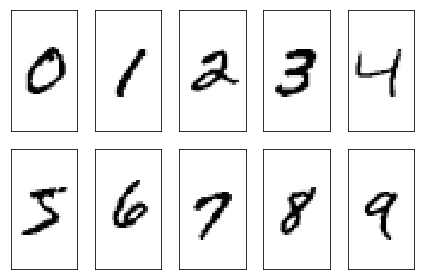

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = x_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


In [4]:
mean_val = np.mean(x_train, axis=0)
std_val = np.std(x_train)
x_train_centered = (x_train - mean_val) / std_val
x_test_centered = (x_test - mean_val) / std_val
del x_train, x_test


In [5]:
def batch_generator(x, y, batch_size=100):
    for i in range(0, x.shape[0], batch_size):
        yield (x[i:i + batch_size, :], y[i:i + batch_size])


In [24]:
import tensorflow as tf


class Model(object):
    def __init__(self, batch_size=100, epochs=20,
                 learning_rate=0.001, random_seed=None):
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.random_seed = random_seed
        np.random.seed(random_seed)
        g = tf.Graph()
        with g.as_default():
            tf.set_random_seed(random_seed)
            self.build()
            self.init_op = tf.global_variables_initializer()
            self.saver = tf.train.Saver()
        self.sess = tf.Session(graph=g)
        self.sess.run(self.init_op)

    def build(self):
        tf_x = tf.placeholder(dtype=tf.float64, shape=[None, 28 * 28], name='tf_x')
        tf_y = tf.placeholder(dtype=tf.int64, shape=[None], name='tf_y')
        print(tf_x)
        print(tf_y)
        y_onehot = tf.one_hot(indices=tf_y, depth=10)
        # 1st layer: dense
        h1 = tf.layers.dense(inputs=tf_x, units=300, activation=tf.nn.relu, name='h1')
        print(h1)
        # 2nd layer: dense
        h2 = tf.layers.dense(inputs=h1, units=100, activation=tf.nn.relu, name='h2')
        print(h2)
        # output layer
        logits = tf.layers.dense(inputs=h2, units=10, activation=None, name='logits')
        print(logits)
        # prediction
        prediction_labels = tf.argmax(logits, axis=1, name='prediction_labels')
        print(prediction_labels)
        # accuracy
        correct = tf.equal(prediction_labels, tf_y)
        accuracy = tf.reduce_mean(tf.cast(correct, tf.float32), name='accuracy')
        # loss function
        loss = tf.losses.softmax_cross_entropy(
            onehot_labels=y_onehot, logits=logits)
        print(loss)
        # optimizer
        optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        train_op = optimizer.minimize(loss=loss, name='train_op')

    def train(self, training_set, validation_set=None):
        x_data = np.array(training_set[0])
        y_data = np.array(training_set[1])
        for epoch in range(1, self.epochs + 1):
            batch = batch_generator(x_data, y_data, batch_size=self.batch_size)
            for _, (x, y) in enumerate(batch):
                feed_dict = {'tf_x:0': x, 'tf_y:0': y}
                self.sess.run('train_op', feed_dict=feed_dict)
            feed_dict = {'tf_x:0': x_data, 'tf_y:0': y_data}
            training_accuracy = self.sess.run('accuracy:0', feed_dict=feed_dict)
            print("Epoch: %2d training accuracy: %6.2f" % (epoch, (100 * training_accuracy)), end=' ')
            if validation_set is not None:
                x_data = np.array(validation_set[0])
                y_data = np.array(validation_set[1])
                feed_dict = {'tf_x:0': x_data, 'tf_y:0': y_data}
                validation_accuracy = self.sess.run('accuracy:0', feed_dict=feed_dict)
                print("validation accuracy: %6.2f" % (100 * validation_accuracy))

    def predict(self, x):
        x = np.array(x)
        feed_dict = {'tf_x:0': x}
        predict_labels = self.sess.run('prediction_labels:0', feed_dict=feed_dict)
        return predict_labels

    def save(self, epoch, path='./model/fc/'):
        if not os.path.isdir(path):
            os.makedirs(path)
        self.saver.save(self.sess, os.path.join(path, 'model.ckpt'), global_step=epoch)
        print('Model saved in %s' % path)


In [25]:
model = Model(random_seed=123)

Tensor("tf_x:0", shape=(?, 784), dtype=float64)
Tensor("tf_y:0", shape=(?,), dtype=int64)
Tensor("h1/Relu:0", shape=(?, 300), dtype=float64)
Tensor("h2/Relu:0", shape=(?, 100), dtype=float64)
Tensor("logits/BiasAdd:0", shape=(?, 10), dtype=float64)
Tensor("prediction_labels:0", shape=(?,), dtype=int64)
Tensor("softmax_cross_entropy_loss/Cast_1:0", shape=(), dtype=float64)


In [26]:
model.train(training_set=(x_train_centered, y_train), validation_set=(x_test_centered, y_test))

Epoch:  1 training accuracy:  96.95 validation accuracy:  96.01
Epoch:  2 training accuracy:  98.19 validation accuracy:  98.19
Epoch:  3 training accuracy:  99.34 validation accuracy:  99.34
Epoch:  4 training accuracy:  99.78 validation accuracy:  99.78
Epoch:  5 training accuracy:  99.96 validation accuracy:  99.96
Epoch:  6 training accuracy:  99.98 validation accuracy:  99.98
Epoch:  7 training accuracy: 100.00 validation accuracy: 100.00
Epoch:  8 training accuracy: 100.00 validation accuracy: 100.00
Epoch:  9 training accuracy: 100.00 validation accuracy: 100.00
Epoch: 10 training accuracy: 100.00 validation accuracy: 100.00
Epoch: 11 training accuracy: 100.00 validation accuracy: 100.00
Epoch: 12 training accuracy: 100.00 validation accuracy: 100.00
Epoch: 13 training accuracy: 100.00 validation accuracy: 100.00
Epoch: 14 training accuracy: 100.00 validation accuracy: 100.00
Epoch: 15 training accuracy: 100.00 validation accuracy: 100.00
Epoch: 16 training accuracy: 100.00 vali

In [28]:
model.save(epoch=model.epochs)

Model saved in ./model/fc/
